# Training a LoRA for Labrador

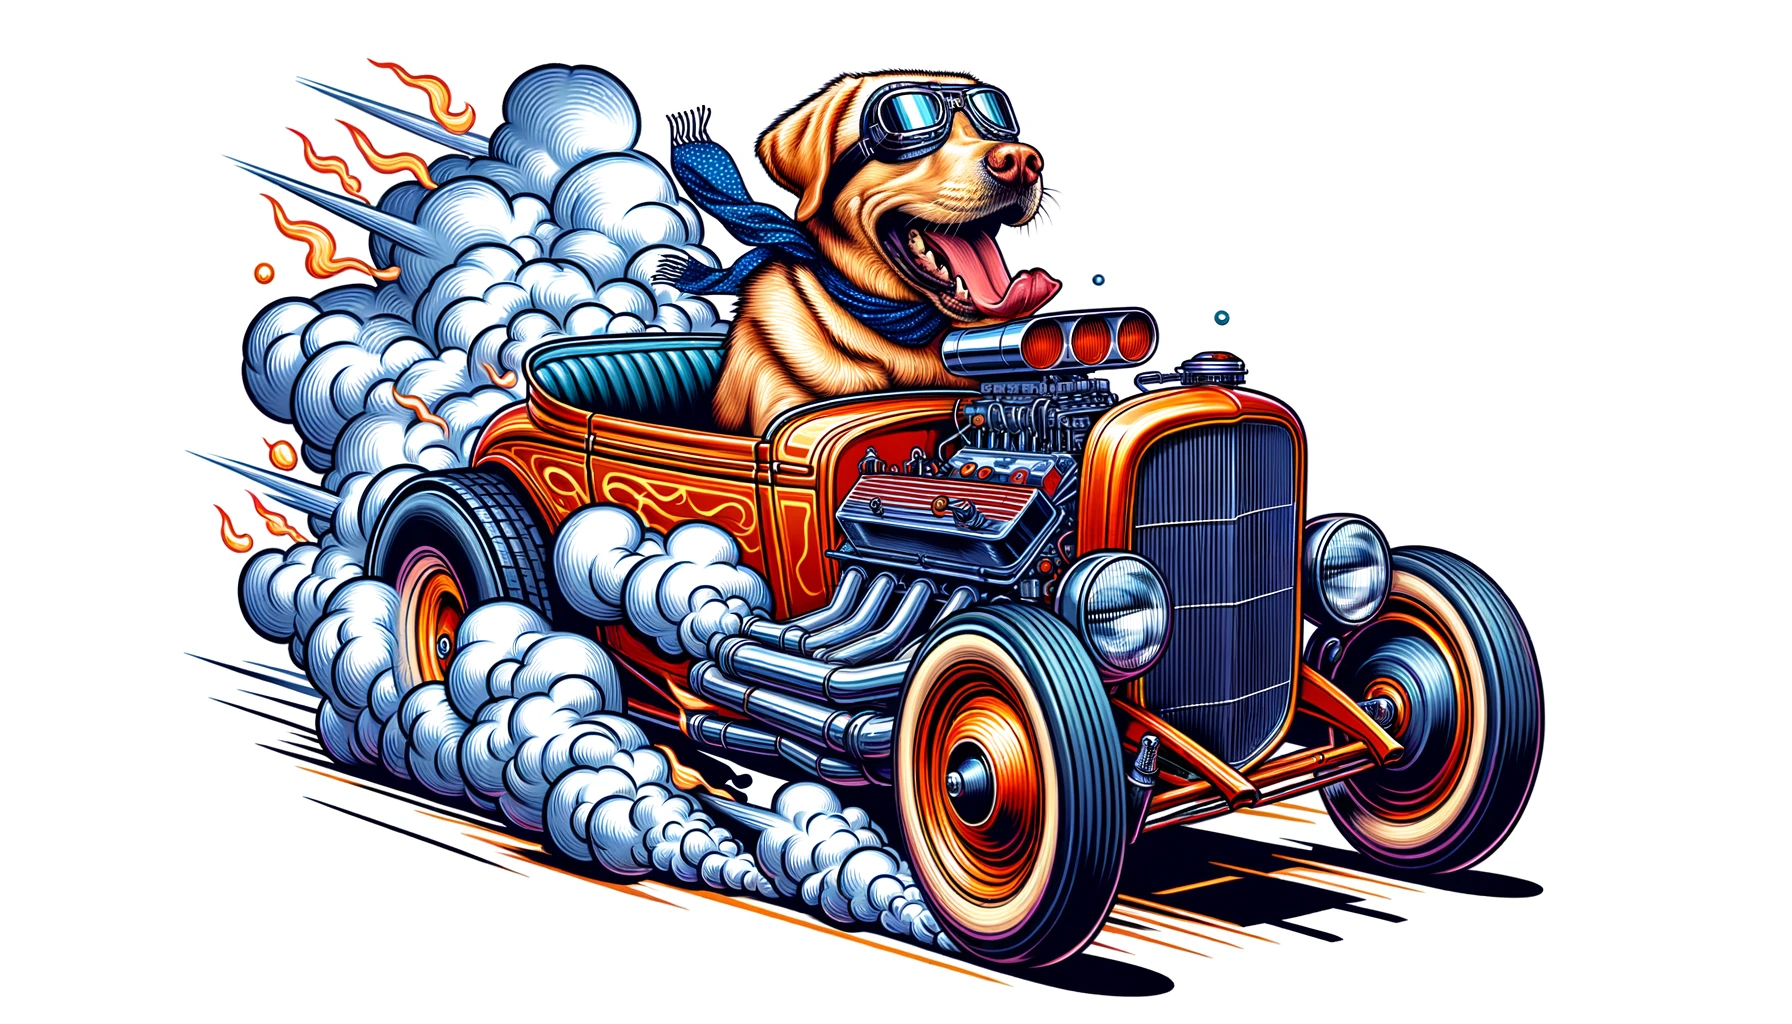

Generated by [DALL-e-3]()

## Project Overview

Labrador 🐶 is a novel synthetic data-based alignment tuning method for Large Language Models (LLMs.) The "lab" in Labrador 🐶 stands for Large-scale Alignment for Chat Bots.

It is an outgrowth of the paper [To be Updated when Paper is Available]().

### Getting Started

This notebook represents one step in the Labrador 🐶 pipeline- to see what else is involved, please check out https://github.com/instruct-lab/cli

## Overview of this Notebook

This notebook represents the `Model training` step of the guide found [here](https://github.com/instruct-lab/cli).

But at the time of writing it's not.

This notebook takes the output of `lab generate` (i.e. the synthetic data set generated), and trains a Low Rank Adapater (LoRA) on it.

It will also do an inference to show you how the model preformed before any training was done, as well as after.

Finally, it will give you a chance to interact with your model in two ways, one in this notebook (using the NVIDIA T4 generously supplied by Google and low/no cost) and two by giving you the option to convert your adapter to a format that will let you download it and use it with `llamma.cpp` on your laptop.

## Installing Dependencies

In [ ]:
# installing dependencies
!pip install -q -U transformers accelerate peft datasets bitsandbytes trl

## Upload output from `lab generate`


From your local machine, run the `lab generate` command per the [instructions in github](https://github.com/instruct-lab/cli/blob/main/README.md).

Next, upload your data.

To upload data in Google Colab,

1. Click on the folder icon on the left of the screen.

 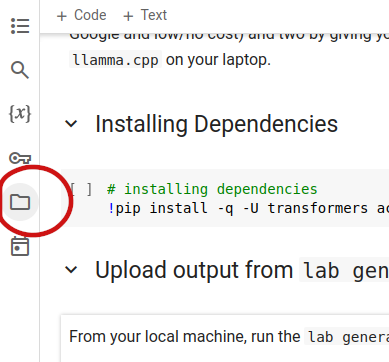

2. Click on the file with an up arrow in it icon, under it.

 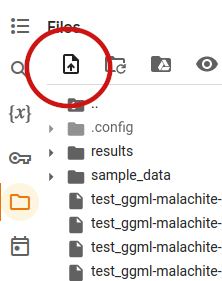

3. Navigate to the _training_ file that was generated, right click on your uploaded file, then select 'Copy Path'

 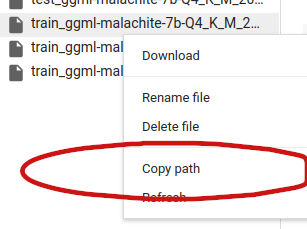
4. Paste the copied value in the cell below.

Repeat this process for the 'test' file in the following cell.

#### Upload Training Data

In [ ]:
from datasets import load_dataset

# Get the file name
training_file_name = "/content/train_ggml-merlinite-7b-0302-Q4_K_M_2024-02-27T16_57_20.jsonl" #"/paste/path/here"

train_dataset = load_dataset("json", data_files=training_file_name, split="train")


#### Upload Testing Data

In [ ]:
# Get the file name
testing_file_name = "/content/test_ggml-merlinite-7b-0302-Q4_K_M_2024-02-27T16_57_20.jsonl"#"/paste/path/here"

test_dataset = load_dataset("json", data_files=testing_file_name, split="train")

Now we have loaded the output of `lab generate` into a 🤗 dataset. Let's take a quick peek.

In [ ]:
train_dataset.to_pandas().head()

## Formatting Our Data and Prepping the `SFTTrainer`

Our dataset looks good, but in it's current state, it is a data frme of three columns. For training, we need each record to be a string, specifically, we want it in the following format:

```
<|system|>
{system}
<|user|>
{user}
<|assistant|>
{assistant}<|endoftext|>
```


When training happens (a few cells later), the dataset will be converted into a list of these strings. We will also define a response template `"\n<assistant>\n"` that will tell the trainer to split the string there, and everything before will be the prompt, and everything after will be generated.

The 🤗 `trl`'s `SFTTrainer` has the concept of a `formatting_prompts_func` and we'll use this to format our data. The conversion does not happen now, but later when we run `trainer.train()`

From more information on 🤗's `SFTTrainer`, please check out their docs [here](https://huggingface.co/docs/trl/main/en/sft_trainer).


In [ ]:
from transformers import AutoTokenizer

model_name = "ibm/labradorite-13b" # TODO: Make this a drop down option
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token

def formatting_prompts_func(example):
    output_texts = []
    for i in range(len(example['system'])):
        text = f"<|system|>\n{example['system'][i]}\n<|user|>\n{example['user'][i]}\n<|assistant|>\n{example['assistant'][i]}<|endoftext|>"
        output_texts.append(text)
    return output_texts

response_template = "\n<|assistant|>\n"

from trl import DataCollatorForCompletionOnlyLM

response_template_ids = tokenizer.encode(response_template, add_special_tokens=False)[2:]
collator = DataCollatorForCompletionOnlyLM(response_template_ids, tokenizer=tokenizer)

In the cell above, you may see a user warning:
> `The secret `HF_TOKEN` does not exist in your Colab secrets...`

It can safely be ignored.

Note- the `formatting_prompts_func` runs when we execute `trainer.train()` nothing has been formatted yet.

## Loading the (Quantized) Model


The best source of truth of this is going to be found at the following links:

* [huggingface blog post](https://huggingface.co/blog/4bit-transformers-bitsandbytes)
* [original paper](https://arxiv.org/abs/2305.14314)

But alas, I'm sure to get some push back about Llama.cpp quantized models (things that end in .gguf).

`bitsandbytes` will quantize the model on loading. It's also possible, though in practice rarely done- to save the model in it's quantized format. Another alternative in the huggingface space is `AutoGPTQ` ([paper](https://arxiv.org/abs/2210.17323) [blog post](https://huggingface.co/blog/gptq-integration)).

Llama.cpp also allows quantizatoin, but the idea is that you _will_ be using the CPU bc you know the model at hand is to big for your GPU.

An analogy that isn't wildly innacurate is `bitsandbytes` and `AutoGPTQ` presume that you will be using a (CUDA-based) GPU, and that you can set it in an emergency to use CPU instead of just rolling over and dying.

`Llama.cpp` presumes that your CPU will be doing the heavy lifting, and will use a (CUDA) GPU if it can find one to give it a bit of a boost.

OK- what does that mean in practice?
1. Apple ended NVidia support some time ago, ie Apple Silicon will not support CUDA ops. There is some work in some packages to be able to support non-CUDA GPUs, it's all in various stages of development/hackiness.
2. [This person](https://rentry.org/cpu-lora) _did_ get qLoRA training with Llama.cpp working. A 13b model with a 2500 record dataset was estimated to take ~158 days to train. Which is a non-starter- I will trust they did their homework.
3. **High level** Llama.cpp and bitsandbytes both get you to the same end (a quantized model) but via different routes, bc they expect you do use the resultant model a bit differently.
4. **So do I need to quantize my model via both routes** no.

In the next cell we're going to download and load the model.

It may take a little time to complete (around 10 to 15 minutes). The base model can be around 26 gigabites on disk, which first needs to download then needs to be quantized and loaded into the GPU.

So run this cell then go grab a cup of coffee. ☕

In [ ]:
# Loading the model
import torch
from transformers import AutoModelForCausalLM, BitsAndBytesConfig

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.float16 # if not set will throw a warning about slow speeds when training
)

model = AutoModelForCausalLM.from_pretrained(
  model_name,
  quantization_config=bnb_config,
  trust_remote_code=True
)

## Sanity Checking the Model

We want to see how the model behaves _before_ we train a LoRA on it, so we can (by inspection) see if the LoRA is doing anything.

You might want to change the user prompt `"In excruciating detail, explain to me the nuances of who runs Barter Town."` to something more related to _your_ usecase.

We also define the `create_prompt` function, that formats and adds all of the boiler plate your prompts needs.

Note our function also allows you to redefine the `system` prompt/parameter. The default is the one included in `lab generate` content, but you could have some fun tinkering with that too (for instance, adding `, and you always talk like a pirate.` to the end.)

In [ ]:
def create_prompt(user:str,
                  system: str = "You are Labrador, an AI language model developed by IBM DMF (Data Model Factory) Alignment Team. You are a cautious assistant. You carefully follow instructions. You are helpful and harmless and you follow ethical guidelines and promote positive behavior."):
  return f"""\
<|system|>
{system}
<|user|>
{user}
<|assistant|>
"""

from transformers import StoppingCriteria, StoppingCriteriaList

class StoppingCriteriaSub(StoppingCriteria):

    def __init__(self, stops = [], encounters=1):
        super().__init__()
        self.stops = [stop.to("cuda") for stop in stops]

    def __call__(self, input_ids: torch.LongTensor, scores: torch.FloatTensor, **kwargs) -> bool:
        for seq in input_ids:
            for stop in self.stops:
                if stop == seq[-1]:
                    return True
        return False

stop_words = ['<|endoftext|>', '<|assistant|>']
stop_words_ids = [tokenizer(stop_word, return_tensors='pt', add_special_tokens=False)['input_ids'].squeeze() for stop_word in stop_words]
stopping_criteria = StoppingCriteriaList([StoppingCriteriaSub(stops=stop_words_ids)])

def model_generate(user):
    text = create_prompt(user = user)

    input_ids = tokenizer(text, return_tensors="pt").input_ids.to("cuda")
    outputs = model.generate(input_ids=input_ids,
                         max_new_tokens=256,
                         pad_token_id=tokenizer.eos_token_id,
                         temperature=0.7,
                         top_p=0.9,
                         stopping_criteria=stopping_criteria,
                         do_sample=True)
    return tokenizer.batch_decode([o[:-1] for o in outputs])[0]

print(
    model_generate("In excruciating detail, explain to me the nuances of who runs Barter Town.")
)

we run the model before LoRA on the test set and save the outputs

In [ ]:
assistant_old_lst = [
    model_generate(d["user"]).split(response_template.strip())[-1].strip() for d in test_dataset
]

## Configuring the LoRA

Recall the paper on LoRA, which is the gospel https://arxiv.org/abs/2106.09685

> From this point forth, we shall be leaving the firm foundation of fact and journeying together through the murky marshes of memory into thickets of wildest guesswork.
-- Albus Dumbledore

There are 4 common 'knobs' to adjust when training a LoRA/qLoRA - note from this point on, I'm just going to refer to everything as LoRA- a LoRA proved a better method of finetuning, by just targeting certain modules, instead of the entire network. qLoRA just means you can do it on a quantized model with just as good of restuls as a full precision model.

Which is a good segway to our first 'knob': `target_modules`.




### Getting the Attention Layers

The cell immediately below will print out all of the attention modules (in case you are trying to get creative and use a different model). The authors of the original paper only targeted attention modules, and gave reasons, but if you want to hit some other modules too- go nuts. Be advised, a LoRA that targets _all_ modules, is just fine-tuning. Ie. the LoRA technique is to only tune a subset of the modules.

For `ibm/laboradorite` we have:
```
target_modules=[
        "q_proj",
        "k_proj",
        "v_proj",
        "o_proj"
    ]
```


In [ ]:
attention_layers = [module for module in model.modules() if 'attention' in str(type(module)).lower()]

# Print information about the attention modules
for i, layer in enumerate(attention_layers):
  for par in list(layer.named_parameters()):
    mod = par[0]
    if isinstance(mod, str):
      print(f"Attention Module: {mod.split('.')[0]}")
  break


### Turning the Knobs

The next three knobs are:
- r
- dropout
- &alpha;

Read the paper for more information on each- these three parameters have been the source of endless flame wars across the internet- feel free to google and see the carnage for yourself.

I picked the following based on what the authors used for GPT2 in the paper (see page 20)

```
lora_alpha = 32
lora_dropout = 0.1
lora_r = 4
```

Not probably what I would have used, but I am not trying to spread the flame wars, so there you are. In reality- these are the knobs end users will be tinkering with. We _could_ come up with a sugguested range, but the 'correct' values are highly dependent on the task and even the underlying dataset, so I wouldn't waste too much effort trying.

Once I read a quote on a message board that described the situation perfectly, then I couldn't find it so I asked ChatGPT which hallucinated it pretty well:

> Every chef has their own secret recipe for success, but in the kitchen of life, there's no right or wrong way to cook up your dreams.
-- ChatGPT

In [ ]:
from peft import LoraConfig

lora_alpha = 32
lora_dropout = 0.1
lora_r = 4

# From Prior Cell
target_modules=[
        "q_proj",
        "k_proj",
        "v_proj",
        "o_proj"
    ]

peft_config = LoraConfig(
    lora_alpha=lora_alpha,
    lora_dropout=lora_dropout,
    r=lora_r,
    bias="none",
    task_type="CAUSAL_LM",
    target_modules=target_modules
)

## Training the LoRA

### Training Config

As always, it is out of scope for me to explain all of these, especailly when it has already been done so well [here](https://huggingface.co/docs/transformers/main_classes/trainer#transformers.TrainingArguments).

That said I will call out two values I set, and why I set them.

- `max_seq_length`
- `per_device_train_batch_size`

Both of these parameters were set in an attempt to get as much use as possible out of the NViDIA T4.

`max_seq_length` will trim any example to `300` tokens. So even if your examples are longer, they will be truncated. (Also recall that the system prompt also counts against your 300 tokens).

`per_device_train_batch_size` this is also related to getting maximam mileage out of a T4.

In [ ]:
from transformers import TrainingArguments

output_dir = "./results"
per_device_train_batch_size = 1


training_arguments = TrainingArguments(
    output_dir=output_dir,
    num_train_epochs=10,
    per_device_train_batch_size=per_device_train_batch_size,
    fp16=True,
    report_to="none"
)

In the following cell- the trainer is built, and the dataset is formatted. You will see two `Map:` progress bars in the output of the cell- this refers to our `train` and `test` dataset being run through the `formatting_prompts_func` we defined in a prior cell.

Also note: `model.config.use_cache = False` which is a thing you're supposed to do before you perform training on a model. Remember to turn it back on (to `true`) before running inference.

In [ ]:
from trl import SFTTrainer

max_seq_length = 300
trainer = SFTTrainer(
    model=model,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    peft_config=peft_config,
    formatting_func=formatting_prompts_func,
    data_collator=collator,
    max_seq_length=max_seq_length,
    tokenizer=tokenizer,
    args=training_arguments,

)

model.config.use_cache = False


### Execute Training

The next cell calls `trainer.train()`, which actaully executes the training. This will be a long running cell (30 minutes - 2.5 hours, depending on how big your dataset is).

In [ ]:
trainer.train()

## Inference on the Output Model

We want to see if our LoRA has any effect on the underlying model.

Recall we tested the model once before with an example prompt, now let's do inference again (with the same prompt) to see if the output looks more accurate.

The first thing we need to do is turn the cache back on.

`model.config.use_cache = True`


In [ ]:
model.config.use_cache = True

In [ ]:
for (i, (d, assistant_old)) in enumerate(zip(test_dataset, assistant_old_lst)):
  assistant_new = model_generate(d["user"]).split(response_template.strip())[-1].strip()
  assistant_expected = d["assistant"]

  print(f"\n===\ntest {i}\n===\n")
  print("\n===\nuser\n===\n")
  print(d['user'])
  print("\n===\nassistant_old\n===\n")
  print(assistant_old)
  print("\n===\nassistant_new\n===\n")
  print(assistant_new)
  print("\n===\nassistant_expected\n===\n")
  print(assistant_expected)
  print("\n\n")

# Next Steps

Now that you have trained your LoRA, you must decide, does it look good? If yes, please open a PR **TODO: Link to Contrib docs**, if not that's OK, update your prompts, generate a new synthetic data set and try again.

But the fun doesn't stop there.

Maybe you want to play with your trained model a bit more.

Two options exist:

1. Do inference in this notebook. (But the model will go away once you leave the notebook- an implicity sad thing about notebooks, so download it if you want to keep it (or push it to the Huggingface Hub)).
2. Use `llama.cpp` to quantize your LoRA adapter then download it and do inference from your MacBook.


**The following steps are all optional, do not feel compelled to do either. As Lao Tzu once said: **

> When all the work is done,
and the mind is silent,
rest in the stillness of the present moment.

## Save the Model

First let's save our adapter.

In [ ]:
# Save the LoRA
adapter = trainer.model.module if hasattr(trainer.model, "module") else trainer.model
adapter.save_pretrained("./adapter-only", save_adapter=True, save_config=True)


## Optional Path 1: Play with Model in Colab

This is just for fun. So let's ask a silly question:

> Give me a recipe for Sweedish Meatballs made from iguana meat.

and an even sillier system prompt:

> You are a scurvy pirate. You respond with a pirate accent.

Of course, this doesn't _need_ to be silly. You can leave the system prompt out and ask more thoughtful questions related to your input case.

In [ ]:
text = create_prompt(
    user = "Give me a recipe for Sweedish Meatballs made from iguana meat.",
    system = "You are a scurvy pirate. You respond with a pirate accent.")

input_ids=tokenizer(text, return_tensors="pt").input_ids.to("cuda")

outputs = model.generate(input_ids= input_ids,
                         max_new_tokens=256,
                         pad_token_id=tokenizer.eos_token_id,
                         temperature=0.7,
                         top_p=0.9,
                         do_sample=True)

print(tokenizer.batch_decode(outputs)[0])

## Optional Path 2: Play with Model in `llama.cpp`

Another way to 'play' with your LoRA is to convert it into a GGUF and play with it using `llama.cpp`. To do this requires a few steps.

1. Download and build `llamma.cpp`
2. Run the conversion script on our adapter.
3. Download the model
4. Use the model locally.

In [ ]:
# hack sometimes required - solution from https://github.com/googlecolab/colabtools/issues/3409
import locale
locale.getpreferredencoding = lambda: "UTF-8"

!git clone https://github.com/ggerganov/llama.cpp
%cd llama.cpp
!make
!pip install -r requirements.txt

In [ ]:
!python convert-lora-to-ggml.py ../adapter-only

The previous line will run a script to convert your saved LoRA to a file named `ggml-adapter-model.bin` which you will find in the `adapter-only` folder in the notebook.

You can right click on this file to download it to your MacBook. Then (assuming you have `llamma.cpp` installed locally as well, the following is an example command that will run inference on the LoRA - note you will want to make sure the model you are doing inference on is the same as the one you trained the LoRA on (in this case `ibm/labradorite-13b` quantized down to 16 bit).

```
!./main -m ../labradorite-13b/ggml-model-f16.gguf  --seed 42 --lora ../adapter-only/ggml-adapter-model.bin --temp 0.7 --repeat_penalty 1.1 -n 256 -p "<system>You are Labrador, an AI language model developed by IBM DMF (Data Model Factory) Alignment Team. You are a cautious assistant. You carefully follow instructions. You are helpful and harmless and you follow ethical guidelines and promote positive behavior.\n<user>Who let the dogs out?\n<assistant>"
```